In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# Q1

By using the same method in the notes to expand the kernel function for some n and d, m can be found.  After expanding, and simplifying, m = number of terms in the polynomial.

c is set to 1.

To avoid tedious calculations, the expansions were done using sympy.

In [3]:
def get_m(n, d):
    """
    Expands and counts the terms in the polynomial kernel function for some n and d, where c = 1
    """
    # Supports n up to 4
    if n == 1:
        x1, z1 = sp.symbols('x1 z1')
        result = sp.expand((x1*z1+1)**d)
    elif n == 2:
        x1, z1, x2, z2 = sp.symbols('x1 z1 x2 z2')
        result = sp.expand((x1*z1+x2*z2+1)**d)
    elif n == 3:
        x1, z1, x2, z2, x3, z3 = sp.symbols('x1 z1 x2 z2 x3 z3')
        result = sp.expand((x1*z1+x2*z2+x3*z3+1)**d)
    elif n == 4:
        x1, z1, x2, z2, x3, z3, x4, z4 = sp.symbols('x1 z1 x2 z2 x3 z3 x4 z4')
        result = sp.expand((x1*z1+x2*z2+x3*z3+x4*z4+1)**d)    
    return str(result).count('+') + 1

# Find m for n = [1, 4], d = [1, 5]
for n in range(1, 5):
    for d in range(1, 6):
        print('n:', n, '  d:', d, '  m:', get_m(n, d))    

n: 1   d: 1   m: 2
n: 1   d: 2   m: 3
n: 1   d: 3   m: 4
n: 1   d: 4   m: 5
n: 1   d: 5   m: 6
n: 2   d: 1   m: 3
n: 2   d: 2   m: 6
n: 2   d: 3   m: 10
n: 2   d: 4   m: 15
n: 2   d: 5   m: 21
n: 3   d: 1   m: 4
n: 3   d: 2   m: 10
n: 3   d: 3   m: 20
n: 3   d: 4   m: 35
n: 3   d: 5   m: 56
n: 4   d: 1   m: 5
n: 4   d: 2   m: 15
n: 4   d: 3   m: 35
n: 4   d: 4   m: 70
n: 4   d: 5   m: 126


The most noticable pattern is that for some $n_1$, $d_1$, $n_2$, $d_2$ where $n_2 = d_1$ and $d_2 = n_1$, $m_1 = m_2$.
For example for $n = 2$, $d = 3$ and $n = 3$, $d = 2$, results in $m = 10$ for both cases.

This suggests there is some term in the relation like $n + d$ or $n * d$ involved for symmetry.

Another pattern is that for larger $n$ and $d$, $m$ grows large quickly. This suggests operations like exponents or factorials may be involved.

Using the above patterns, the final equation below was found to relate $n$, $d$, and $m$:

$$m = \frac{(n + d)!}{n! d!}$$

# Q2

# Getting the data into Python

In [4]:
# Load the txt as a numpy array of strings, 
# because it includes the column headers
raw_data = np.loadtxt('as6_data.txt', delimiter=' ', dtype=str)

# Convert everything into floats!
clean_data = np.array(raw_data, dtype=float)

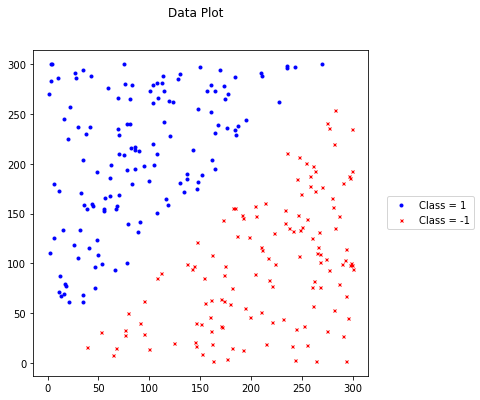

In [5]:
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then -1's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==-1, :-1]

pos, neg = split_pos_neg(clean_data)

x1_pos = pos[:, 0].flatten()
x2_pos = pos[:, 1].flatten()
x1_neg = neg[:, 0].flatten()
x2_neg = neg[:, 1].flatten()

plt.figure(figsize=(6,6))
plt.plot(x1_pos,x2_pos,'bo', markersize=3)
plt.plot(x1_neg,x2_neg,'rx', markersize=3)
plt.suptitle('Data Plot')
plt.legend(['Class = 1', 'Class = -1'],bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

In [6]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float array) the percentages of the data you want to be TRAINING, VALIDATION, and TESTING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

In [7]:
training, test = get_sets(clean_data, .5)

# Initializing alpha

In [8]:
import random

def init_lagrange_multipliers(data):
    # Find positions where the labels are -1, and 1 respectively
    neg = np.where(data[:, 2] == -1)[0]
    pos = np.where(data[:, 2] == 1)[0]
    
    y = data[:, 2]
    alpha = np.array([random.randint(0, 100) for _ in y], dtype=float)
    
    # Calculate the sum of the product of the labels and alpha values
    t = sum(y * np.transpose(alpha))
    
    # If the sum is positive, 
    # then increment a random alpha value corresponding to a negative label
    while t > 0:
        i = np.random.choice(neg)
        alpha[i] += 1
        t = sum(y * np.transpose(alpha))
        
    # If the sum is negative, 
    # then increment a random alpha value corresponding to a positive label
    while t < 0:
        i = np.random.choice(pos)
        alpha[i] += 1
        t = sum(y * np.transpose(alpha))
        
    return alpha

In [9]:
alpha = init_lagrange_multipliers(training)
print(alpha)

# Initialize b to 0
b = 0

[ 74.  32.  54.  67.  95.  36.  50.  68. 127. 119.  67.  57.  47.  76.
  56.  56.  26.  71.  80. 113.  94.  57.  24.  47.  36.  97. 105.  39.
  66.  11.  21.  72.  42.  21.  97.  67.  26.  42.  69.  52.  78.  32.
  78.  43.  13. 118.  46.  71.  67. 100.   1.  82.  38.  93.  16.  95.
  61.  64.  79. 109.  61.  64.  53.  71.  63.  74.  93.  11.  11.  87.
  81.  56.  68.  30.  54.  95. 111.  58.  96.  47.  71.  46. 108.  22.
  40.  36.  76.  52.  94.  23.  54.  73.  57.  57.  90.  64. 108.   7.
 116.  64.  17.  19.  40.  51.  47.  72.  86.   5.  83.  65.  67. 117.
  15. 107.  74.  62. 114.  86.  87. 123.  42.  53.  88. 101. 120.  32.
  69.  75. 100.  94.   2.  54.  21.]


In [10]:
sum(training[:, 2] * np.transpose(alpha))

0.0

# SMO Algorithm

In [11]:
# Lets make a helper function to split up our X and Y matrices
def split_input_output(data):
    """
    Splits the input array into two seperate sets:
        * the feature values
        * the output value
        
    :returns: (tuple) the features are the first element, the outputs are the second
    """
    return np.delete(data, [data.shape[1] - 1], axis=1), data[:, -1]

def get_weights():
    # Always use x_train, y_train
    vec = np.zeros(x_train.shape[1])
    for i in range(y_train.shape[0]):
        vec += alpha[i] * y_train[i] * x_train[i]
    return vec

x_train, y_train = split_input_output(training)
x_test, y_test = split_input_output(test)

weights = get_weights()

weights

array([-609545.,  393503.])

In [12]:
def classify(x, i):
    # classify values > 0 to 1, otherwise -1
    weights = get_weights()
    return np.sign(np.dot(weights, x[i]) + b)

def KKT(x, y, i):
    weights = get_weights()
    return alpha[i] * (y[i] * (np.dot(weights, x[i]) + b) - 1)

def K(x, i, j):
    return np.dot(x[i], x[j])

def E(x, y, i):
    val = 0
    for j in range(y.shape[0]):
        val += alpha[j] * y[j] * K(x, j, i)
    return val - y[i]

def e(x, y, i1, i):
    return E(x, y, i1) - E(x, y, i)

# Helper argmax function
def argmax(f, x):
    vec_fn = np.vectorize(f)
    
    return np.argmax(vec_fn(x))

In [13]:
def accuracy(classified_y, test_y):
    comp = (classified_y == test_y)
    return np.count_nonzero(comp) / len(comp)

def classify_data(x):
    return np.array([classify(x, i) for i in range(x.shape[0])])


In [14]:
accuracy(classify_data(x_test), y_test)

0.8872180451127819

In [15]:
epsilon = 0.1

# Update alpha until classified. Using accuracy to test. (Steps 2 - 9)
# Stop after 15 epochs as the algorithm is not fully working
epochs = 0
while accuracy(classify_data(x_train), y_train) < 1 and epochs < 15:
    i1 = argmax(lambda i: KKT(x_train, y_train, i), range(y_train.shape[0]))
    x1 = x_train[i1]
    i2 = argmax(lambda i: e(x_train, y_train, i1, i), range(y_train.shape[0]))
    x2 = x_train[i2]    
    
    # Calc k = K11 + K22 - 2K12
    k = K(x_train, i1, i1) + K(x_train, i2, i2) - (2 * K(x_train, i1, i2))
    
    # Update alpha 2
    old_alpha_2 = alpha[i2]
    alpha[i2] = old_alpha_2 + ((y_train[i2] * e(x_train, y_train, i1, i2)) / k)
    
    # Update alpha 1
    alpha[i1] = alpha[i1] + (y_train[i1] * y_train[i2] * (old_alpha_2 - alpha[i2]))
    
    # Prune alphas
    for i in range(len(alpha)):
        if alpha[i] < epsilon:
            alpha[i] = 0
    
    # Calculate b
    s = 0
    for i in np.where(alpha > 0)[0]:
        s += (((KKT(x_train, y_train, i) / alpha[i]) + 1) / y_train[i]) - np.dot(get_weights(), x_train[i])
        
    s /= len(np.where(alpha > 0)[0])
    b = s
    print("B = ", b)
        
    
    acc = accuracy(classify_data(x_train), y_train)
    print('New Accuracy:', acc)
    epochs += 1

B =  -2.8221896200469047e-10
New Accuracy: 0.40601503759398494
B =  2.2749864418088024e-10
New Accuracy: 0.40601503759398494
B =  1.3649918650852815e-09
New Accuracy: 0.40601503759398494
B =  -1.5014910515938095e-08
New Accuracy: 0.40601503759398494
B =  9.55494305559697e-09
New Accuracy: 0.40601503759398494
B =  -1.910988611119394e-08
New Accuracy: 0.40601503759398494
B =  -6.005964206375238e-08
New Accuracy: 0.40601503759398494
B =  -7.643954444477576e-08
New Accuracy: 0.40601503759398494
B =  5.823965291030534e-08
New Accuracy: 0.40601503759398494
B =  1.4559913227576336e-07
New Accuracy: 0.40601503759398494
B =  2.911982645515267e-07
New Accuracy: 0.40601503759398494
B =  -5.823965291030535e-07
New Accuracy: 0.40601503759398494
B =  1.4559913227576337e-06
New Accuracy: 0.40601503759398494
B =  -9.318344465648855e-07
New Accuracy: 0.40601503759398494
B =  -3.028461951335878e-06
New Accuracy: 0.40601503759398494


Test Accuracy: 0.5789473684210527


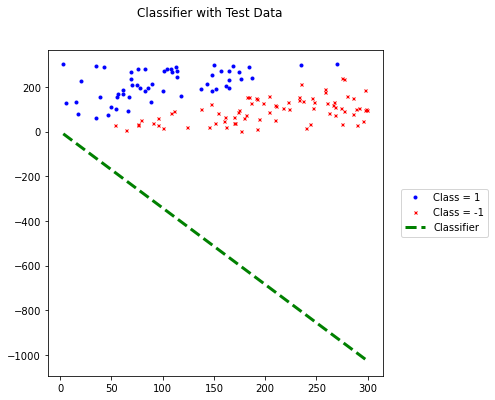

In [16]:
print('Test Accuracy:', accuracy(classify_data(x_test), y_test))

pos, neg = split_pos_neg(test)

x1_pos = pos[:, 0].flatten()
x2_pos = pos[:, 1].flatten()
x1_neg = neg[:, 0].flatten()
x2_neg = neg[:, 1].flatten()

plt.figure(figsize=(6,6))
plt.plot(x1_pos,x2_pos,'bo', markersize=3)
plt.plot(x1_neg,x2_neg,'rx', markersize=3)


xh = np.arange(x1_pos.min(), x2_pos.max() + 1)
w_x = float(get_weights()[0])
w_y = float(get_weights()[1])
# Rearranged the decision line w.x - b = 0 for y
yh = (-xh * w_x + b) / w_y
plt.plot(xh,yh,'g--', linewidth=3)

plt.suptitle('Classifier with Test Data')
plt.legend(['Class = 1', 'Class = -1', 'Classifier'],bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

# Analysis

The algorithm is not working as expected. If the algorithm is left to run through many 'epochs' or times to update alpha, then one alpha is always updated and approaches infinity.  The calculations for b seem to also be incorrect.  Both of these result in the classifier being negative and below the data set, incorrectly classifying about half of the data.

Below is an image of the classifier using the initial langrange multipliers/alpha values before selected alpha values are updated. This classifier is close to what is expected, although the margin should be larger.

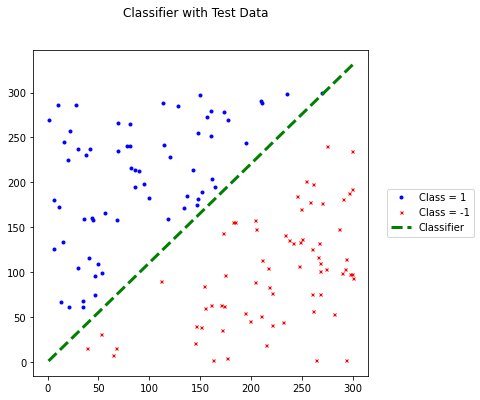